# plot_ripple_trace

plot ripple example for figure 1

In [1]:
import pickle
import numpy as np
# plotting
from matplotlib import pyplot as plt
import dabest
import pandas as pd
from scipy import stats
import h5py
import sys,os
import glob
from ripple_detection import filter_ripple_band
from scipy import signal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Continuous Wavelet Transform
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt


Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# plt.style.use('seaborn-paper')

# params = {'legend.fontsize': 'large',
#          'axes.labelsize': 'large',
#          'axes.titlesize':'large',
#          'xtick.labelsize':'large',
#          'ytick.labelsize':'large'}
# plt.rcParams.update(params)

# plt.rcParams.update({'font.size': 13})
# %config InlineBackend.figure_format = 'retina'

In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

In [2]:
# import matplotlib as mpl

# pdf_with_latex = {                      # setup matplotlib to use latex for output
#     "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
# #     "text.usetex": True,                # use LaTeX to write all text
#     "font.family": "serif",
#     "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
# #     "font.sans-serif": [],
#     "font.monospace": [],
#     "axes.labelsize": 8,               # LaTeX default is 10pt font.
#     "font.size": 7,
#     "legend.fontsize": 7,               # Make the legend/label fonts a little smaller
#     "xtick.labelsize": 7,
#     "ytick.labelsize": 7,
#     "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
#         r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
#         ],
# #     "lines.markeredgewidth" : 0.2,
#     "axes.linewidth"        : 0.8,
#     "ytick.major.size"      : 1.5,
#     "xtick.major.size"      : 1.5
#     }  
# mpl.rcParams.update(pdf_with_latex)

## helper functions

In [3]:
def loadXML(path):
    """
    path should be the folder session containing the XML file
    Function returns :
        1. the number of channels
        2. the sampling frequency of the dat file or the eeg file depending of what is present in the folder
            eeg file first if both are present or both are absent
        3. the mappings shanks to channels as a dict
    Args:
        path : string
    Returns:
        int, int, dict
    """
    if not os.path.exists(path):
        print("The path "+path+" doesn't exist; Exiting ...")
        sys.exit()
    listdir = os.listdir(path)
    xmlfiles = [f for f in listdir if f.endswith('.xml')]
    if not len(xmlfiles):
        print("Folder contains no xml files; Exiting ...")
        sys.exit()
    new_path = os.path.join(path, xmlfiles[0])

    from xml.dom import minidom
    xmldoc = minidom.parse(new_path)
    nChannels = xmldoc.getElementsByTagName('acquisitionSystem')[0].getElementsByTagName('nChannels')[0].firstChild.data
    fs_dat = xmldoc.getElementsByTagName('acquisitionSystem')[0].getElementsByTagName('samplingRate')[0].firstChild.data
    fs = xmldoc.getElementsByTagName('fieldPotentials')[0].getElementsByTagName('lfpSamplingRate')[0].firstChild.data

    shank_to_channel = {}
    groups = xmldoc.getElementsByTagName('anatomicalDescription')[0].getElementsByTagName('channelGroups')[0].getElementsByTagName('group')
    for i in range(len(groups)):
        shank_to_channel[i] = np.sort([int(child.firstChild.data) for child in groups[i].getElementsByTagName('channel')])
    return int(nChannels), int(fs), shank_to_channel

def loadLFP(path, n_channels=90, channel=64, frequency=1250.0, precision='int16'):
    if type(channel) is not list:
        f = open(path, 'rb')
        startoffile = f.seek(0, 0)
        endoffile = f.seek(0, 2)
        bytes_size = 2
        n_samples = int((endoffile-startoffile)/n_channels/bytes_size)
        duration = n_samples/frequency
        interval = 1/frequency
        f.close()
        with open(path, 'rb') as f:
            data = np.fromfile(f, np.int16).reshape((n_samples, n_channels))[:,channel]
            timestep = np.arange(0, len(data))/frequency
            return data, timestep # nts.Tsd(timestep, data, time_units = 's')
        
    elif type(channel) is list:
        f = open(path, 'rb')
        startoffile = f.seek(0, 0)
        endoffile = f.seek(0, 2)
        bytes_size = 2

        n_samples = int((endoffile-startoffile)/n_channels/bytes_size)
        duration = n_samples/frequency
        f.close()
        with open(path, 'rb') as f:
            data = np.fromfile(f, np.int16).reshape((n_samples, n_channels))[:,channel]
            timestep = np.arange(0, len(data))/frequency
            return data,timestep # nts.TsdFrame(timestep, data, time_units = 's')
        
def get_session_path(session):
    f = h5py.File(session,'r')
    return f['session_path'][()].tobytes()[::2].decode()

def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

def get_lfp(df,i):
    data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'

    # get data session path from mat file
    path = get_session_path(data_path+df.session[i]+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    # load .lfp
    # lfp, ts = load_lfp(glob.glob(path +'\*.lfp')[0],channels,fs)
    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs,
                     precision='int16')
    return lfp,ts

def normalize(list, range):
    l = np.array(list) 
    a = np.max(l)
    c = np.min(l)
    b = range[1]
    d = range[0]
    m = (b - d) / (a - c)
    pslope = (m * (l - c)) + d
    return pslope

def get_scalogram(sig,fs=1250,padding=100,f_min=150,f_max=250,fig=1,ax=0):
    
    # sample difference
    dt = 1/fs
    # pad signal
    sig_padded = np.pad(sig, (padding, padding), 'linear_ramp')
    # get time stamps
    t = np.linspace(0, dt * len(sig), len(sig))
    # get scalogram
    scalogram = cwt(sig_padded, dt, 8, f_min, f_max)
    # delete padding
    scalogram = np.delete(scalogram, np.s_[1:padding+1], axis=1) 
    scalogram = np.delete(scalogram, np.s_[-(padding+1):-1], axis=1) 
    
    # plot figure
    if fig==1:
        cmap = plt.get_cmap('magma')
        if ax == 0:
            fig = plt.figure()
            ax = fig.add_subplot(111)

        x, y = np.meshgrid(
            t,
            np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

        im = ax.pcolormesh(x, y, np.abs(scalogram), cmap=cmap,shading='auto')
        ax.set_rasterized(True)
        ax.plot(t,normalize(sig,[f_min,f_max]),color='w',linewidth=1)
        ax.set_ylabel("Frequency [Hz]")
        ax.set_ylim(f_min, f_max)
        # ax.set_yscale('log')
        if ax == 0:
            plt.show()
    
    return np.abs(scalogram),im

## Load data

In [4]:
with open('F:/Projects/PAE_PlaceCell/swr_data/post_processed/swr_df_maps.pkl', 'rb') as f:
    df = pickle.load(f)
    ripple_map = pickle.load(f)
    filtered_map = pickle.load(f)
    phase_map = pickle.load(f)
    amp_map = pickle.load(f)
    freq_map = pickle.load(f)
    
df = df.reset_index()
df['ripple_number'] = np.arange(0,len(df),1)

df = df.drop(columns=['index'])
df

,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,rat
0,0,66.2624,66.3792,0.1168,0.997065,66.3112,3,6.221621,174.029756,0.000000,LEM3116_S20180715121821,LEM3116
1,1,149.9824,150.1512,0.1688,0.989532,150.1128,1,6.893002,217.563367,0.006667,LEM3116_S20180715121821,LEM3116
2,2,343.5024,343.5952,0.0928,0.995268,343.5472,3,7.195949,212.566470,0.000000,LEM3116_S20180715121821,LEM3116
3,3,344.2784,344.4000,0.1216,0.988154,344.3720,3,5.758124,230.841531,0.000000,LEM3116_S20180715121821,LEM3116
4,4,441.4600,441.6208,0.1608,0.986499,441.5536,4,5.181640,158.973213,0.000000,LEM3116_S20180715121821,LEM3116
...,...,...,...,...,...,...,...,...,...,...,...,...
52602,52602,115.8936,116.0488,0.1552,0.445488,115.9440,4,5.989715,209.285805,0.000000,RH16_S20161207130000,RH16
52603,52603,769.6008,769.6736,0.0728,0.170989,769.6200,2,7.993862,192.961786,0.006667,RH16_S20161207130000,RH16
52604,52604,1106.5360,1106.6128,0.0768,0.118062,1106.5720,2,9.221199,205.013810,0.000000,RH16_S20161207130000,RH16
52605,52605,1189.0416,1189.2408,0.1992,0.142649,1189.1168,2,7.268366,205.098888,0.013333,RH16_S20161207130000,RH16


## find sessions for ripple example

In [ ]:
# x_range = 2
# rip_n = 21568
# temp_df = df[df.session == df.session[rip_n]]
# n_ripples = []
# for i in temp_df.index:
#     n_ripples.append(sum((temp_df.peak_time >= df.peak_time[i] - x_range/2) & (temp_df.peak_time <= df.peak_time[i] + x_range/2)))
    
# max(n_ripples) 
# temp_df.iloc[np.argmax(n_ripples)]


In [ ]:
# temp_df = df[df.session == df.session[rip_n]]

# temp_df[(temp_df.peak_time >= df.peak_time[rip_n] - x_range/2) & (temp_df.peak_time <= df.peak_time[rip_n] + x_range/2)]

## Chose ripple number, load data, and plot

In [5]:
rip_n = 21568
# rip_n = 21682
lfp,ts = get_lfp(df,rip_n)

filter_ripple_band(lfp)
LFPs = lfp
filtered_lfps = np.stack([filter_ripple_band(lfp, 1250) for lfp in LFPs.T])
filtered_lfps = filtered_lfps.T

x_range = .5
idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
temp_df = df[df.session == df.session[rip_n]]

## get average trace over session

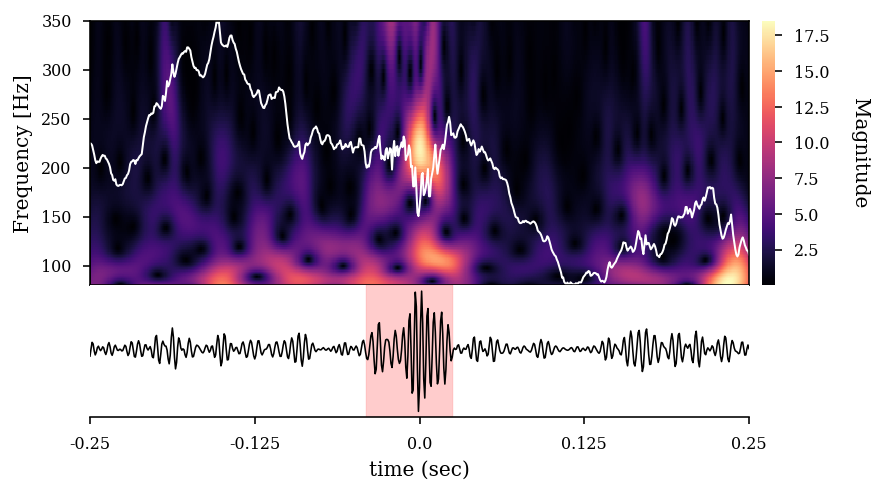

In [11]:
# set up figure
fig = plt.figure(figsize=set_size(426.79135,subplots=(1,1)),constrained_layout=False)
fig.subplots_adjust(hspace = 0, wspace=0.5)
gs = fig.add_gridspec(3, 1)
f_ax1 = fig.add_subplot(gs[0:2, :])
f_ax2 = fig.add_subplot(gs[2, :])

# plot scalogram
_,im = get_scalogram(lfp[idx,df.peak_channel[rip_n]],1250,f_min=80,f_max=350,ax=f_ax1)
f_ax1.set_xlabel('time (sec)')
f_ax1.get_xaxis().set_visible(False)

# set up parameters for colorbar
axins = inset_axes(f_ax1,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=f_ax1.transAxes,
                   borderpad=0,
                   )
# plot colorbar
cbar = fig.colorbar(im,ax=f_ax1,cax=axins)
cbar.set_label('Magnitude', rotation=270, labelpad=20)
cbar.outline.set_visible(False)

# plot filtered trace
f_ax2.plot(ts[idx],filtered_lfps[idx,df.peak_channel[rip_n]],color='k',linewidth=0.8)
for ripple in temp_df[(temp_df.peak_time >= df.peak_time[rip_n] - x_range/2) & (temp_df.peak_time <= df.peak_time[rip_n] + x_range/2)].itertuples():
    f_ax2.axvspan(ripple.start_time, ripple.end_time, alpha=0.2, color='red', zorder=-1000) # #fec287
    
f_ax2.autoscale(enable=True, axis='x', tight=True)

# align x axis
locs = f_ax2.get_xticks()
labels = f_ax2.get_xticklabels()
f_ax2.set_xticks(np.linspace(min(ts[idx]), max(ts[idx]), 5))
f_ax2.set_xticklabels(np.linspace(-x_range/2,x_range/2,5))

# name x axis
f_ax2.set_xlabel('time (sec)')

# clean up y axis and box
f_ax2.get_yaxis().set_visible(False)
right_side = f_ax2.spines["right"]
right_side.set_visible(False)
left_side = f_ax2.spines["left"]
left_side.set_visible(False)
top_side = f_ax2.spines["top"]
top_side.set_visible(False)

# save plot
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_trace_spectro.svg',dpi=900,bbox_inches='tight')

In [12]:
# session = 'LEM3216_S20190812175606'

# lfp,ts = get_lfp(df,np.where(df.session == session)[0][0])

# x_range = .1
# rip = []
# for ripple in df[df.session == session].itertuples():

#     idx = (ts >= ripple.peak_time - x_range/2) & (ts <= ripple.peak_time + x_range/2)

# #     rip.append(stats.zscore(signal.detrend(lfp[idx,df.peak_channel[rip_n]])))
#     rip.append(stats.zscore(lfp[idx,df.peak_channel[rip_n]]))

# rip = np.vstack(rip)
# rip = np.delete(rip, np.where(np.sum(np.isnan(rip),axis=1) > 1), 0) 

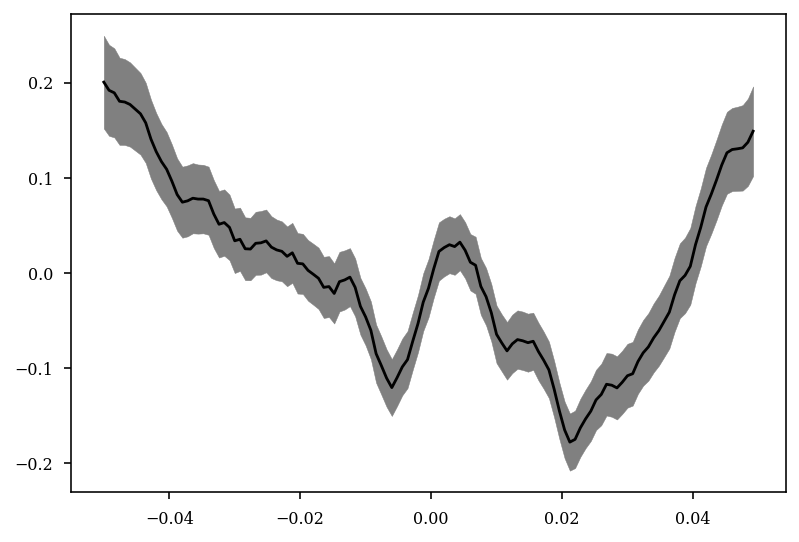

In [13]:

# x = np.arange(-x_range/2,x_range/2,1/1250)
# y = np.mean(rip,axis=0)
# error = np.std(np.vstack(rip),axis=0) / np.sqrt(len(rip)) 

# plt.fill_between(x, y-error, y+error,color = 'grey')
# plt.plot(x,y,color = 'black')
# plt.show()